### data augmentation. 
ref: https://github.com/pytorch/vision/blob/main/references/segmentation/transforms.py 


In [37]:
import cv2
import time
import torch
import random
import numpy as np 
from glob import glob
import rasterio as rio 
from notebooks import config
from utils.imgShow import imsShow 
from utils.dataloader import SceneArraySet, PatchPathSet_2
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from utils.dataloader import read_scenes 


In [38]:
patch_size = 512  ## patch size setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
print(f'vali patch: {len(paths_valset)}')


train scenes: 48
vali patch: 293


In [39]:
scenes_arr, truths_arr, scenes_lat = read_scenes(paths_scene_tra, 
                                        paths_truth_tra, 
                                        paths_dem_tra)


In [75]:
scene_truth = np.concatenate([scenes_arr[0], truths_arr[0][:, :, np.newaxis]], axis=-1)
print(scene_truth.shape)  # (H, W, C+2) 


(1737, 1713, 8)


### numpy to tensor

In [455]:
print(scene_truth.shape)
scene_truth_ = v2.ToImage()(scene_truth)  # to PIL Image
print(scene_truth_.shape)


(1737, 1713, 8)
torch.Size([8, 1737, 1713])


### random cropping

In [467]:
crop_random = v2.RandomCrop(size=(512, 512), padding = 128)
patch_ptruth = crop_random(scene_truth_)
# resize_random = v2.Resize(size=(256, 256))  # resize to 256x256
# patch_ptruth = resize_random(patch_ptruth)
patch, dem, ptruth = patch_ptruth[0:6], patch_ptruth[6:7], patch_ptruth[7:]  ## separate patch and truth
patch, dem, ptruth = patch.numpy().transpose((1, 2, 0)), dem.numpy().transpose((1, 2, 0)), ptruth.numpy().transpose((1, 2, 0))


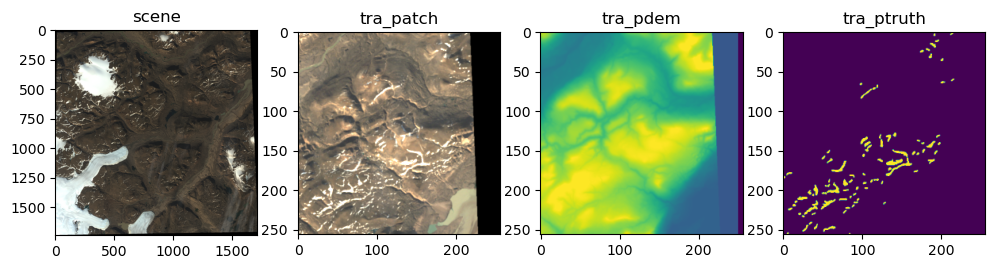

In [466]:
imsShow([scene_truth_.numpy().transpose((1, 2, 0)), patch, dem, ptruth], 
              clip_list=[2, 2,2,2], img_name_list=['scene','tra_patch','tra_pdem','tra_ptruth'], figsize=(12, 3)) 


### random flipping

In [117]:
flip_h_random = v2.RandomHorizontalFlip(p=0.5)  
flip_v_random = v2.RandomVerticalFlip(p=0.5)  
patch_ptruth_ = flip_h_random(patch_ptruth)  
patch_ptruth_ = flip_v_random(patch_ptruth_)  
patch_, dem_, ptruth_ = patch_ptruth_[0:6], patch_ptruth_[6:7], patch_ptruth_[7:]  ## separate patch and truth
patch_, dem_, ptruth_ = patch_.numpy().transpose((1, 2, 0)), dem_.numpy().transpose((1, 2, 0)), ptruth_.numpy().transpose((1, 2, 0))


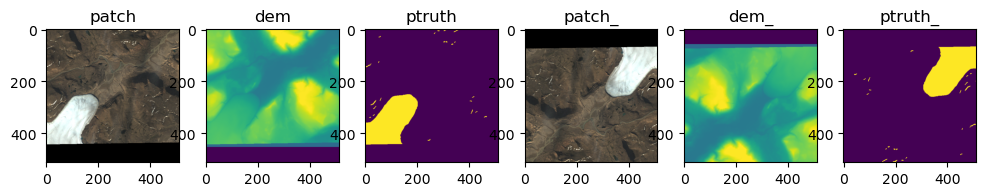

In [118]:
imsShow([patch, dem, ptruth, patch_, dem_, ptruth_], 
              clip_list=[2, 2,2,2,2,2], img_name_list=['patch','dem','ptruth','patch_','dem_','ptruth_'], figsize=(12, 3)) 


### random rotation

In [132]:
transform_random = v2.RandomRotation(degrees=180)  
patch_ptruth_ = transform_random(patch_ptruth)  
patch_, dem_, ptruth_ = patch_ptruth_[0:6], patch_ptruth_[6:7], patch_ptruth_[7:]  ## separate patch and truth
patch_, dem_, ptruth_ = patch_.numpy().transpose((1, 2, 0)), dem_.numpy().transpose((1, 2, 0)), ptruth_.numpy().transpose((1, 2, 0))



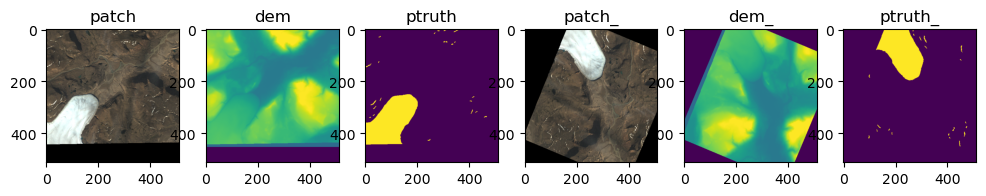

In [133]:
imsShow([patch, dem, ptruth, patch_, dem_, ptruth_], 
              clip_list=[2, 2,2,2,2,2], img_name_list=['patch','dem','ptruth','patch_','dem_','ptruth_'], figsize=(12, 3)) 


### random noisy

In [445]:
class GaussianNoise(v2.GaussianNoise):
    def __init__(self, mean = 0.0, sigma_max=0.1, p=0.5):
        super().__init__()
        self.mean = mean
        self.sigma_max = sigma_max
        self.p = p
    def transform(self, inpt, params):
        self.sigma = torch.rand(1)*self.sigma_max
        if torch.rand(1) < self.p:
            return super().transform(inpt, params)
        else:
            return inpt
transform_random = GaussianNoise(mean = 0, sigma_max=0.03, p=0.3)  
patch_ptruth_ = transform_random(patch_ptruth)  
patch_, dem_, ptruth_ = patch_ptruth_[0:6], patch_ptruth_[6:7], patch_ptruth_[7:]  ## separate patch and truth
patch_, dem_, ptruth_ = patch_.numpy().transpose((1, 2, 0)), dem_.numpy().transpose((1, 2, 0)), ptruth_.numpy().transpose((1, 2, 0))



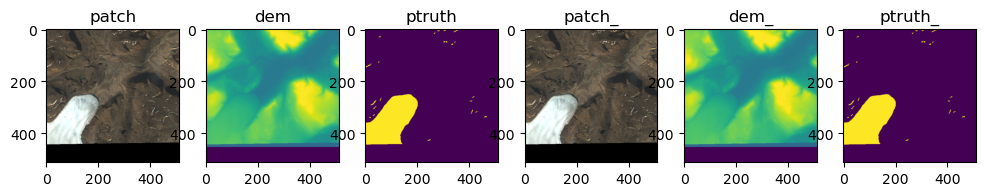

In [446]:
imsShow([patch, dem, ptruth, patch_, dem_, ptruth_], 
              clip_list=[2, 2, 2, 2, 2, 2], img_name_list=['patch','dem','ptruth','patch_','dem_','ptruth_'], figsize=(12, 3)) 


### merge all data augmentation

In [ ]:
## combine transforms
transforms_geom = v2.Compose([
    v2.ToImage(),
    v2.RandomCrop(size=(512, 512), padding = 128),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=180),    
])

transforms_color = v2.Compose([
    GaussianNoise(mean = 0, sigma_max=0.03, p=0.3)
]) 


In [412]:
patch_dem_truth_ = transforms_geom(scene_truth)
patch_dem_ = patch_dem_truth_[0:-1]
patch_dem_ = transforms_color(patch_dem_)
patch_, dem_, ptruth_ = patch_dem_[0:6], patch_dem_[6:7], patch_dem_truth_[7:]  ## separate patch and truth
patch_, dem_, ptruth_ = patch_.numpy().transpose((1, 2, 0)), dem_.numpy().transpose((1, 2, 0)), ptruth_.numpy().transpose((1, 2, 0))


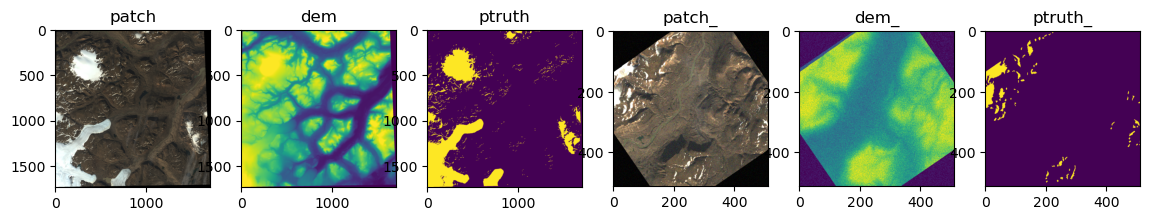

In [413]:
scene, sdem, struth = scenes_arr[0][:,:,0:6], scenes_arr[0][:,:,6], truths_arr[0]
imsShow([scene, sdem, struth, patch_, dem_, ptruth_], 
              clip_list=[2, 2, 2, 2, 2, 2], 
              img_name_list=['patch','dem','ptruth','patch_','dem_','ptruth_'], 
              figsize=(14, 3)) 
